# Mean field variance dynamics for noisy signal propagation

In [1]:
# imports
import os, sys, pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines

# custom import
from src.numpy_simulation import *
# from src.simulation import *
from src.viz import get_colours
from src.utils import load_experiment
from src.theory import depth
from src.theory import critical_point

# plot settings
import matplotlib as mpl
# mpl.rcParams['figure.figsize'] = [14.0, 6.0]
mpl.rcParams['font.size'] = 100

sns.set_context("paper", font_scale=2)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
plt.rcParams['image.cmap'] = 'viridis'
# plt.rcParams.update({'font.size': 50})

# results directory
relative_results_dir = "results"
results_dir = os.path.join(relative_results_dir)

## --- Variance map: Theory vs simulation ---

In [2]:
experiments = [
    {"dist": "none", "noise": (None, None), "act":"tanh", "init":"xavier"}, 
    {"dist": "add gauss", "noise": ('std', 1), "act":"tanh", "init":"xavier"},
    {"dist": "none", "noise": (None, None), "act":"relu", "init":"he"},
    {"dist": "add gauss", "noise": ('std', 1), "act":"relu", "init":"he"}
]

for i, experiment in enumerate(experiments):
    dist = experiment['dist']
    noise = experiment['noise']
    act = experiment['act']
    init = experiment['init']
    
    # run simulations for scenario
    noisy_signal_prop_simulations(dist, noise, act, init, seed=i)

####### EXPERIMENT: dist:  none ;  None :  None ; activation:  tanh ; initialisation:  xavier ##############
qmap calculations...
Calculating Theory:



Simulating network
Single layer sims...



####### EXPERIMENT: dist:  add gauss ;  std :  1 ; activation:  tanh ; initialisation:  xavier ##############
qmap calculations...
Calculating Theory:



Simulating network
Single layer sims...



####### EXPERIMENT: dist:  none ;  None :  None ; activation:  relu ; initialisation:  he ##############
qmap calculations...
Calculating Theory:



Simulating network
Single layer sims...
Setting activation to ReLU...



####### EXPERIMENT: dist:  add gauss ;  std :  1 ; activation:  relu ; initialisation:  he ##############
qmap calculations...
Calculating Theory:



Simulating network
Single layer sims...
Setting activation to ReLU...


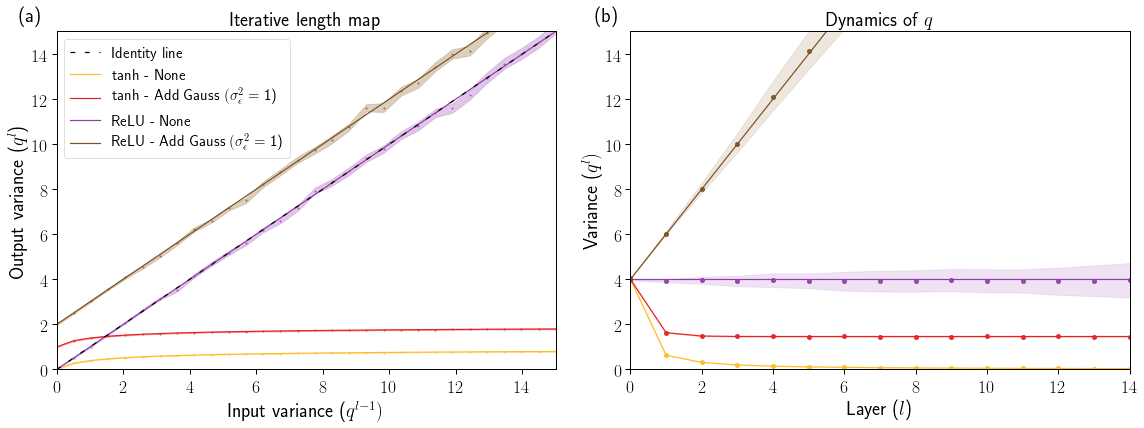

In [8]:
# Dictionary for data that needs to be extracted

tests = [{
        "distributions": [{"dist": "none"}],
        "activations": ["tanh"],
        "inits": ["xavier"]
    }, {
        "distributions": [{"dist": "add gauss", "std": 1}],
        "activations": ["tanh"],
        "inits": ["xavier"]
    }, {
        "distributions": [{"dist": "none"}],
        "activations": ["relu"],
        "inits": ["he"]
    }, {
        "distributions": [{"dist": "add gauss", "std": 1}],
        "activations": ["relu"],
        "inits": ["he"]
    }]


############################################################################
############################################################################
# q - length / variance plots
############################################################################
############################################################################
nq = 30
qmax = 15
qrange = np.linspace(0, qmax, nq)
widxs = [0]
bidxs = [0]
n_hidden_layers = 16

n_tests = len(tests)
#pal = get_colours(10, 7)
pal = get_colours(6, 7)[2:]
test_data = []
for i, test in enumerate(tests):
    test_data.append(load_experiment(test, ["q_maps", "single_layer_qmap_sim", "multi_layer_qmap_sim"], "results"))

fig = plt.figure(figsize=(16, 6))

gs = plt.GridSpec(1, 2)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

# Add unity line
ax1.plot((0, qmax), (0, qmax), '--', color='k', zorder=900, dashes=(4, 8), label="Identity line")
ax1.set_xlim(0, qmax)
ax1.set_ylim(0, qmax)
ax1.set_xlabel('Input variance ($q^{l-1})$')
ax1.set_ylabel('Output variance ($q^l$)')
ax1.set_title("Iterative length map")

# axis 2
ax2.set_xlim(0, qmax-1) #n_hidden_layers-1)
ax2.set_ylim(0, qmax)
ax2.set_xlabel('Layer ($l$)')
ax2.set_ylabel('Variance ($q^{l})$')
ax2.set_title("Dynamics of $q$")

nn = len(test_data)
col_i = 0
shade_i = 5
for test, attr in zip(test_data, tests):
    for dist in attr["distributions"]:
        for act in attr["activations"]:
            if dist['dist'] == "none":
                if act == "tanh":
                    label = "tanh - None"
                    col_i = 0
                else:
                    label = "ReLU - None"
                    col_i = 2
            elif "gauss" in dist['dist']: 
                if act == "tanh":
                    label = "tanh - Add Gauss $(\sigma^2_\epsilon = $ " + str(dist['std']) + ")"
                    col_i = 1
                else:
                    label = "ReLU - Add Gauss $(\sigma^2_\epsilon = $ " + str(dist['std']) + ")"
                    col_i = 3
            for init in attr["inits"]:
                dashes = (None, None)
                
                
                # extract test data
                qmaps = test[dist['dist']][act][init]['q_maps']['qmaps']
                single_layer_sims = test[dist['dist']][act][init]['single_layer_qmap_sim']
                multi_layer_sims = test[dist['dist']][act][init]['multi_layer_qmap_sim']['qmaps_sim']
                multi_layer_theory = test[dist['dist']][act][init]['multi_layer_qmap_sim']['theory']
                

                ############################################################################
                # left
                ############################################################################
                for w, b in zip(widxs, bidxs):

                    # plot means of simulation (as dots)
                    mu = single_layer_sims[w, b].mean(-1).mean(-2)
                    ax1.plot(qrange, mu, w, b, marker='o', ls='none', markersize=1, alpha=0.9, zorder=0, c=pal[col_i][shade_i])

                    # add confidence interval around simulation
                    std = single_layer_sims[w, b].mean(-1).std(-2)
                    ax1.fill_between(qrange, mu-std, mu+std, alpha=0.4, label='_nolegend_', color=pal[col_i][3])

                    # theory line
                    ax1.plot(qrange, qmaps[0, 0, :, 1], c=pal[col_i][shade_i], label=label, dashes=dashes)
                    

                ############################################################################
                # right
                ############################################################################
                q = 1
                xx = np.arange(multi_layer_sims.shape[-2])
                for w, b in zip(widxs, bidxs):
                    # confidence intervals
                    mu = multi_layer_sims[w, b].mean(axis=-1).mean(axis=0)
                    std = multi_layer_sims[w, b].mean(axis=-1).std(axis=0)

                    # plot theory
                    ax2.plot(multi_layer_theory, c=pal[col_i][shade_i], label="Theory")

                    # plot the simulation
                    ax2.fill_between(xx, mu-std, mu+std, alpha=0.2, label='_nolegend_', color=pal[col_i][3])

                    # dots for mean
                    ax2.plot(xx, mu, 'o', markersize=4, alpha=0.9, color=pal[col_i][shade_i], label="Simulation")

##############
# add labels #
##############
fig.text(0.02, 0.95, "(a)", fontsize=20)
fig.text(0.52, 0.95, "(b)", fontsize=20)

ax1.legend(prop={'size': 15})
plt.gcf().tight_layout()
plt.savefig("tanh.pdf")